In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nw

import clean

In [2]:
g = nw.DiGraph()

In [3]:
df = clean.parse_json_to_df('data/raw-test.json')

In [4]:
df = df[~df['ingredients'].isnull()]
df['course'] = df.attributes.apply(lambda x: x['course'] if x.has_key('course') else [])
df['cuisine'] = df.attributes.apply(lambda x: x['cuisine'] if x.has_key('cuisine') else [])
df_cuisine = df[df['cuisine'].apply(lambda x: len(x)>0)]
df_course = df[df['course'].apply(lambda x: len(x)>0)]


In [5]:
df_desserts = df[df['course'].apply(lambda x: 'Desserts' in x)]

# Build the Graph

For the graph, nodes are ingredients. This analysis looks at how ingredients are connected to each other. Edges are a result of recipes that use these ingredients. Here are some hypothesis hoping to answer:
- a logical connection between similar ingredients can be discovered by recipes that connect them together
- a logical indicator of the most important ingredients in any kitchen

In [7]:
# work with a smaller subset of data
df_subset = df.iloc[map(int,np.floor(np.random.uniform(0,len(df), 1000)))]

In [8]:

def make_ingredient_graph(df_set, blacklist = []):
    g = nw.DiGraph()
    recipe_l = df_set['recipeName'].tolist()
    ingredient_l = df_set['ingredients'].tolist()
    for i in xrange(len(df_set)):
        ingredients = ingredient_l[i]
        recipe_name = recipe_l[i]


        # remove some super common ingredients
        for b in blacklist:
            if b in ingredients:
                ingredients.remove(b)
        # add the ingredient to the hash of nodes before adding edges
        for ing in ingredients:
            if not g.has_node(ing):
                g.add_node(ing)
        # add edges to each node now
        for ing in ingredients:
    #         nodes[ing]['recipes'].append(row['recipeName'])
            for ig in [ig for ig in ingredients if ig != ing]:
                if not g.edge[ing].has_key(ig):
                    g.add_weighted_edges_from([(ing, ig,0)])
                g.edge[ing][ig]['weight'] += 1
    return g

def page_rank_graph(g):
    ranks = nw.pagerank(g)
    df_ranks = pd.DataFrame(map(lambda x: dict(ingredient=x, prob=ranks[x]), ranks))
    return df_ranks.sort('prob', ascending=False)

In [9]:
g_desserts = make_ingredient_graph(df_desserts)
g_sampled = make_ingredient_graph(df_subset, blacklist=['salt'])

In [10]:
pr = page_rank_graph(g_sampled)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:31: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


KeyError: 0

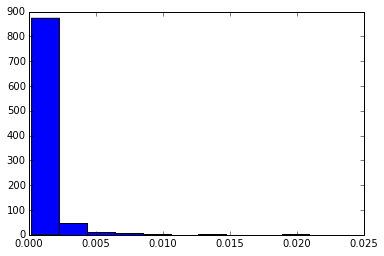

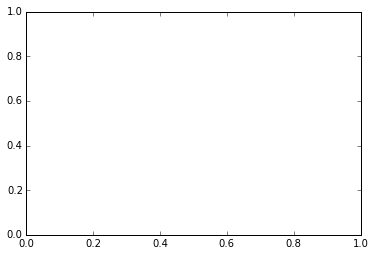

In [11]:
plt.hist(pr['prob'])
plt.figure()
plt.hist(pr.iloc[int(len(pr)/2.):len(pr)-1]['prob'])

In [13]:
page_rank_graph(g_desserts)

,ingredient,prob
24,sugar,0.059090
239,unsalted butter,0.054924
270,salt,0.047113
104,heavy cream,0.030391
172,all-purpose flour,0.026122
193,granulated sugar,0.026017
152,large eggs,0.023967
40,vanilla extract,0.020380
210,pure vanilla extract,0.017839
125,water,0.014540


In [47]:
id_map = {}
i = 0
for g in g_sampled.node.keys():
    if not id_map.has_key(g):
        id_map[g] = i
        i += 1

In [48]:
pd.DataFrame({'Label':g_sampled.node.keys(), 'Id': xrange(len(g_sampled.node))}, ).to_csv(
    'data/sampled_nodes.csv', index=False, encoding='utf-8'
)

In [54]:
edges = []
for e in g_sampled.edge:
    for e2 in g_sampled.edge[e]:
        for i in xrange(g_sampled.edge[e][e2]['weight']):
            edges.append(dict(
                source=id_map[e],
                target=id_map[e2],
                ))


In [55]:
pd.DataFrame(edges).to_csv(
    'data/sampled_edges.csv', index=False,encoding='utf-8'
)